In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
sns.set()

import math
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(7)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/DSAI Project/Data/Tetuan City power consumption.csv")
data

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [ ]:
target = []
for x, y, z in zip(data["Zone 1 Power Consumption"], data["Zone 2  Power Consumption"], data["Zone 3  Power Consumption"]):
  target.append(float(x) + float(y) + float(z))
data["Target"] = pd.Series(target)
data.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,Target
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,65489.23209
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,63650.44627


In [ ]:
data = data.drop(["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows", "Zone 1 Power Consumption", "Zone 2  Power Consumption", "Zone 3  Power Consumption"], axis = 1)
data.set_index("DateTime", inplace = True)
data.head()

,Target
DateTime,
2017-01-01 00:00:00,70425.53544
2017-01-01 00:10:00,69320.84387
2017-01-01 00:20:00,67803.22193
2017-01-01 00:30:00,65489.23209
2017-01-01 00:40:00,63650.44627


In [ ]:
data = data["2017-12-16 00:00:00":]
data

,Target
DateTime,
2017-12-16 00:00:00,61346.07666
2017-12-16 00:10:00,59841.73153
2017-12-16 00:20:00,58469.28636
2017-12-16 00:30:00,57239.78104
2017-12-16 00:40:00,56161.60690
...,...
2017-12-30 23:10:00,72798.08659
2017-12-30 23:20:00,70983.80786
2017-12-30 23:30:00,68675.04965


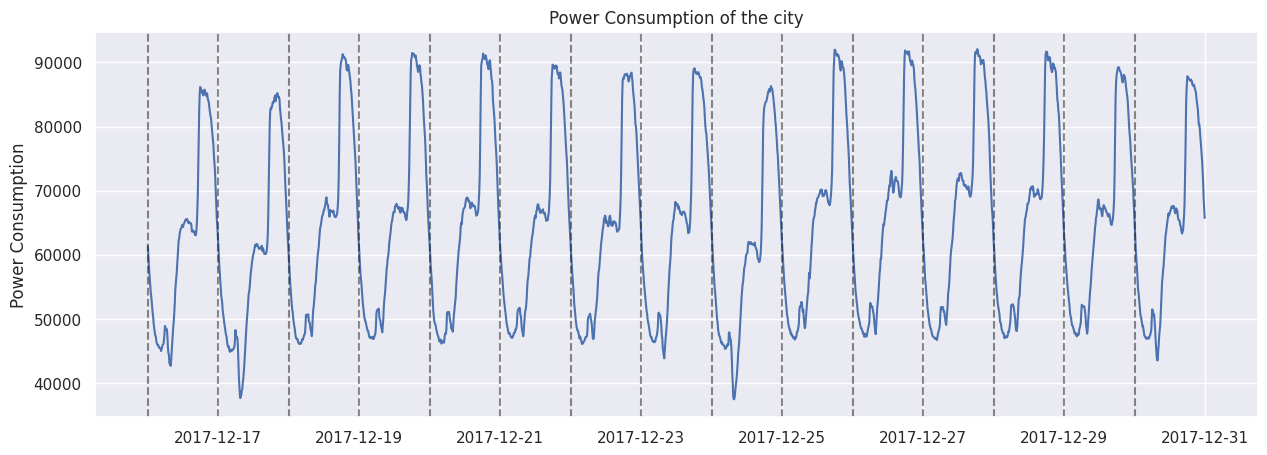

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(data.Target)
plt.title("Power Consumption of the city")
plt.ylabel("Power Consumption")
for day in range(16, 31):
    plt.axvline(pd.to_datetime("2017-12-" + str(day) + " 00:00:00"), color='k', linestyle='--', alpha=0.5)

In [ ]:
dataset = data.values
dataset

array([[61346.07666],
       [59841.73153],
       [58469.28636],
       ...,
       [68675.04965],
       [67163.01682],
       [65750.53976]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset

array([[0.43733372],
       [0.40976562],
       [0.38461467],
       ...,
       [0.57164189],
       [0.54393291],
       [0.51804835]])

In [ ]:
def train_test_split (dataset, train_size = 0.7):
  train_size = int(len(dataset) * train_size)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test

In [ ]:
train, test = train_test_split (dataset, train_size = 0.7)
print(len(train), len(test))

1512 648


In [ ]:
train, val = train_test_split (train, train_size = 0.7)
print(len(train), len(val))

1058 454


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(1056, 1)
(452, 1)
(646, 1)


In [ ]:
# (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# **Building models**

## **Vanilla LSTM**

In [ ]:
look_back = 1
def simple_vanilla_LSTM(input_shape = (1, look_back)):
  model = Sequential()
  model.add(LSTM(8, input_shape=input_shape))
  model.add(Dense(4, activation = "relu"))
  # model.add(Dropout(0.2))
  model.add(Dense(1, activation = "linear"))
  model.summary()

  return model

In [ ]:
vanilla = simple_vanilla_LSTM()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 8)                 320       
                                                                 
 dense_9 (Dense)             (None, 4)                 36        
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


## **Stacked LSTM**

In [ ]:
def stacked_LSTM(input_shape = (1, look_back)):
  model = Sequential()
  model.add(LSTM(8, input_shape= input_shape, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(8))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "linear"))
  model.summary()

  return model

In [ ]:
stacked = stacked_LSTM()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 8)              320       
                                                                 
 dropout_6 (Dropout)         (None, 1, 8)              0         
                                                                 
 lstm_11 (LSTM)              (None, 8)                 544       
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


# **Training model**

## **Vanilla LSTM**

In [ ]:
vanilla.compile(loss = "mean_squared_error", optimizer='adam')

In [ ]:
# Train model
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
vanilla_es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
vanilla_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
vanilla_mcp = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/DSAI Project/Code/vanilla_LSTM.h5', monitor = 'val_loss', 
                      save_best_only = True, verbose = 1)

In [ ]:
steps_per_epoch = trainX.shape[0]
validation_step = valX.shape[0]
# Fiting the model.
history = vanilla.fit(trainX, trainY, validation_data= (valX, valY), epochs = 50, steps_per_epoch = steps_per_epoch, callbacks = [vanilla_es, vanilla_rlr, vanilla_mcp], validation_steps = validation_step)

Epoch 1/50
1041/1056 [============================>.] - ETA: 0s - loss: 0.0583
Epoch 1: val_loss improved from inf to 0.00627, saving model to /content/gdrive/MyDrive/DSAI Project/Code/vanilla_LSTM.h5
1056/1056 [==============================] - 7s 5ms/step - loss: 0.0575 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/50
1044/1056 [============================>.] - ETA: 0s - loss: 7.4388e-04
Epoch 2: val_loss improved from 0.00627 to 0.00047, saving model to /content/gdrive/MyDrive/DSAI Project/Code/vanilla_LSTM.h5
1056/1056 [==============================] - 5s 5ms/step - loss: 7.3979e-04 - val_loss: 4.7381e-04 - lr: 0.0010
Epoch 3/50
1056/1056 [==============================] - ETA: 0s - loss: 4.8867e-04
Epoch 3: val_loss did not improve from 0.00047
1056/1056 [==============================] - 5s 5ms/step - loss: 4.8867e-04 - val_loss: 5.8107e-04 - lr: 0.0010
Epoch 4/50
1055/1056 [============================>.] - ETA: 0s - loss: 5.0454e-04
Epoch 4: val_loss did not improve from 0.00047
10

In [ ]:
model = load_model("/content/gdrive/MyDrive/DSAI Project/Code/vanilla_LSTM.h5")

In [ ]:
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform([valY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

21/21 [==============================] - 0s 2ms/step
Train Score: 1127.15 RMSE
Test Score: 1157.74 RMSE


In [ ]:
mean_absolute_percentage_error(testY[0], testPredict[:,0])

1.1772472661648783

In [ ]:
testPredict

array([[68641.89 ],
       [69676.06 ],
       [70269.266],
       [70874.64 ],
       [70770.18 ],
       [72080.03 ],
       [72618.52 ],
       [73108.43 ],
       [72642.67 ],
       [71141.93 ],
       [70336.32 ],
       [69723.516],
       [70124.445],
       [70899.33 ],
       [71723.516],
       [71596.88 ],
       [72168.125],
       [71771.96 ],
       [71615.52 ],
       [71507.   ],
       [71482.02 ],
       [71083.57 ],
       [70447.69 ],
       [69566.516],
       [69106.96 ],
       [69271.74 ],
       [69003.34 ],
       [69399.305],
       [70329.266],
       [71397.45 ],
       [73729.7  ],
       [77832.66 ],
       [83231.75 ],
       [88078.945],
       [90683.28 ],
       [91468.98 ],
       [91042.48 ],
       [91138.54 ],
       [91291.29 ],
       [91159.555],
       [91331.555],
       [91057.97 ],
       [90933.59 ],
       [91345.49 ],
       [90731.34 ],
       [90286.95 ],
       [89908.93 ],
       [89785.62 ],
       [89437.96 ],
       [90167.99 ],


In [ ]:
testY

array([[69654.302581, 70247.42348 , 70852.39087 , 70748.01548 ,
        72056.2479  , 72593.84892 , 73082.87461 , 72617.95978 ,
        71119.41473 , 70314.45018 , 69701.76355 , 70102.6498  ,
        70877.06108 , 71700.26162 , 71573.80211 , 72144.20904 ,
        71748.65012 , 71592.42252 , 71484.05115 , 71459.09736 ,
        71061.11767 , 70425.7502  , 69544.73652 , 69084.94185 ,
        69249.83294 , 68981.22622 , 69377.46151 , 70307.39572 ,
        71374.63556 , 73703.00953 , 77801.81785 , 83226.1959  ,
        88154.60211 , 90871.35997 , 91870.18891 , 91327.47094 ,
        91449.59337 , 91643.92478 , 91476.31935 , 91695.17544 ,
        91347.15031 , 91189.10722 , 91712.91764 , 90932.34166 ,
        90425.65265 , 90035.49674 , 89908.35497 , 89550.2128  ,
        90302.80737 , 90124.11446 , 89690.08228 , 89531.262   ,
        88923.72919 , 87481.46427 , 86387.41987 , 85909.73781 ,
        84640.70134 , 83669.60517 , 82348.86166 , 81099.37327 ,
        79951.51868 , 78095.95689 , 7648

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
# shift val predictions for plotting
valPredictPlot = np.empty_like(dataset)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict) + (look_back*2) + 1:len(trainPredict) + (look_back*2) + 1 + len(valPredict), :] = valPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :] = testPredict

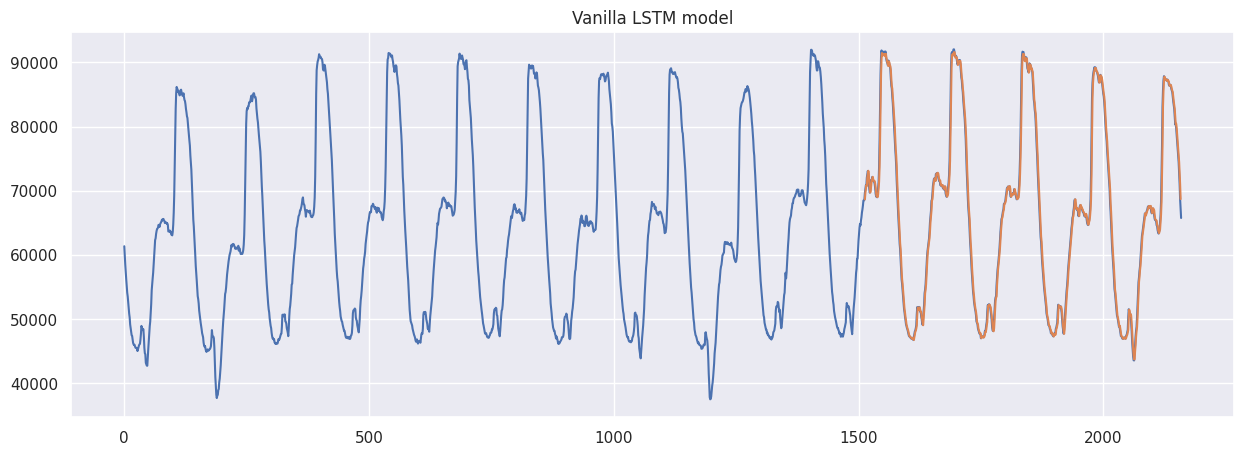

In [ ]:
# plot baseline and predictions
plt.figure(figsize = (15,5))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(valPredictPlot)
plt.plot(testPredictPlot)
# plt.legend(('Actual data', 'Prediction for Training data', 'Prediction for Validation data', 'Prediction for Testing data'), loc='upper left')
# plt.legend(('Actual data', 'Prediction for Testing data'), loc='upper left')
plt.title("Vanilla LSTM model")
plt.show()

In [ ]:
df = data.values
actualTest = df[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :]
predictTest = testPredictPlot[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :]

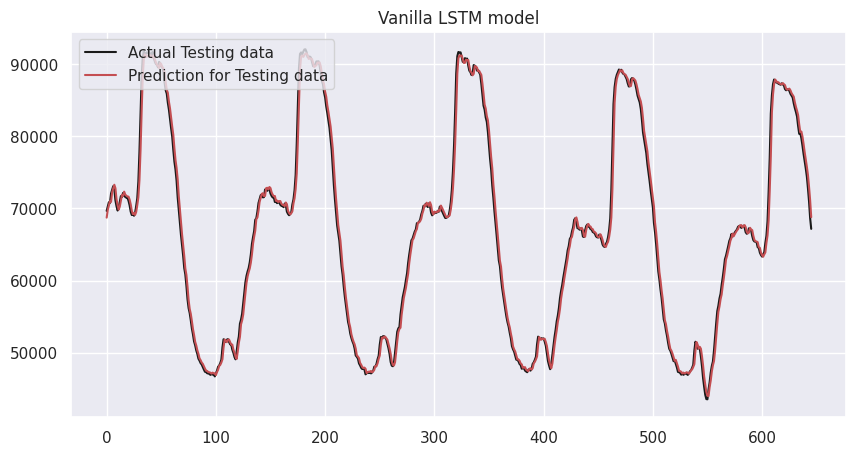

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(actualTest,'k-')
plt.plot(predictTest,'r-')
plt.legend(('Actual Testing data', 'Prediction for Testing data'), loc='upper left')
plt.title("Vanilla LSTM model")
plt.show()

## **Stacked LSTM**

In [ ]:
dataset

array([[0.43733372],
       [0.40976562],
       [0.38461467],
       ...,
       [0.57164189],
       [0.54393291],
       [0.51804835]])

In [ ]:
train, test = train_test_split (dataset, train_size = 0.7)
train, val = train_test_split (train, train_size = 0.7)
print(train.shape)
print(val.shape)
print(test.shape)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(valX.shape)
print(testX.shape)

(1058, 1)
(454, 1)
(648, 1)
(1056, 1)
(452, 1)
(646, 1)


In [ ]:
# (samples, timesteps, features)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX

array([[[0.43733372]],

       [[0.40976562]],

       [[0.38461467]],

       ...,

       [[0.13471094]],

       [[0.12578675]],

       [[0.11703553]]])

In [ ]:
trainY

array([0.40976562, 0.38461467, 0.36208319, ..., 0.12578675, 0.11703553,
       0.1382666 ])

In [ ]:
stacked.compile(loss = "mean_squared_error", optimizer='adam')

In [ ]:
# Train model
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
stacked_es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
stacked_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
stacked_mcp = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/DSAI Project/Code/stacked_LSTM.h5', monitor = 'val_loss', 
                      save_best_only = True, verbose = 1)

In [ ]:
steps_per_epoch = trainX.shape[0]
validation_step = valX.shape[0]
# Fiting the model.
history = stacked.fit(trainX, trainY, validation_data= (valX, valY), epochs = 50, steps_per_epoch = steps_per_epoch, callbacks = [stacked_es, stacked_rlr, stacked_mcp], validation_steps = validation_step)

Epoch 1/50
1051/1056 [============================>.] - ETA: 0s - loss: 0.0538
Epoch 1: val_loss improved from inf to 0.00518, saving model to /content/gdrive/MyDrive/DSAI Project/Code/stacked_LSTM.h5
1056/1056 [==============================] - 12s 8ms/step - loss: 0.0535 - val_loss: 0.0052 - lr: 0.0010
Epoch 2/50
1047/1056 [============================>.] - ETA: 0s - loss: 0.0119
Epoch 2: val_loss improved from 0.00518 to 0.00342, saving model to /content/gdrive/MyDrive/DSAI Project/Code/stacked_LSTM.h5
1056/1056 [==============================] - 6s 6ms/step - loss: 0.0119 - val_loss: 0.0034 - lr: 0.0010
Epoch 3/50
1053/1056 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 3: val_loss improved from 0.00342 to 0.00236, saving model to /content/gdrive/MyDrive/DSAI Project/Code/stacked_LSTM.h5
1056/1056 [==============================] - 6s 6ms/step - loss: 0.0096 - val_loss: 0.0024 - lr: 0.0010
Epoch 4/50
1052/1056 [============================>.] - ETA: 0s - loss: 0.00

In [ ]:
model = load_model("/content/gdrive/MyDrive/DSAI Project/Code/stacked_LSTM.h5")

In [ ]:
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform([valY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

21/21 [==============================] - 0s 2ms/step
Train Score: 1339.18 RMSE
Test Score: 1321.77 RMSE


In [ ]:
mean_absolute_percentage_error(testY[0], testPredict[:,0])

1.5503217148332116

In [ ]:
testPredict.shape

(646, 1)

In [ ]:
testY.shape

(1, 646)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
# shift val predictions for plotting
valPredictPlot = np.empty_like(dataset)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(trainPredict) + (look_back*2) + 1:len(trainPredict) + (look_back*2) + 1 + len(valPredict), :] = valPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :] = testPredict

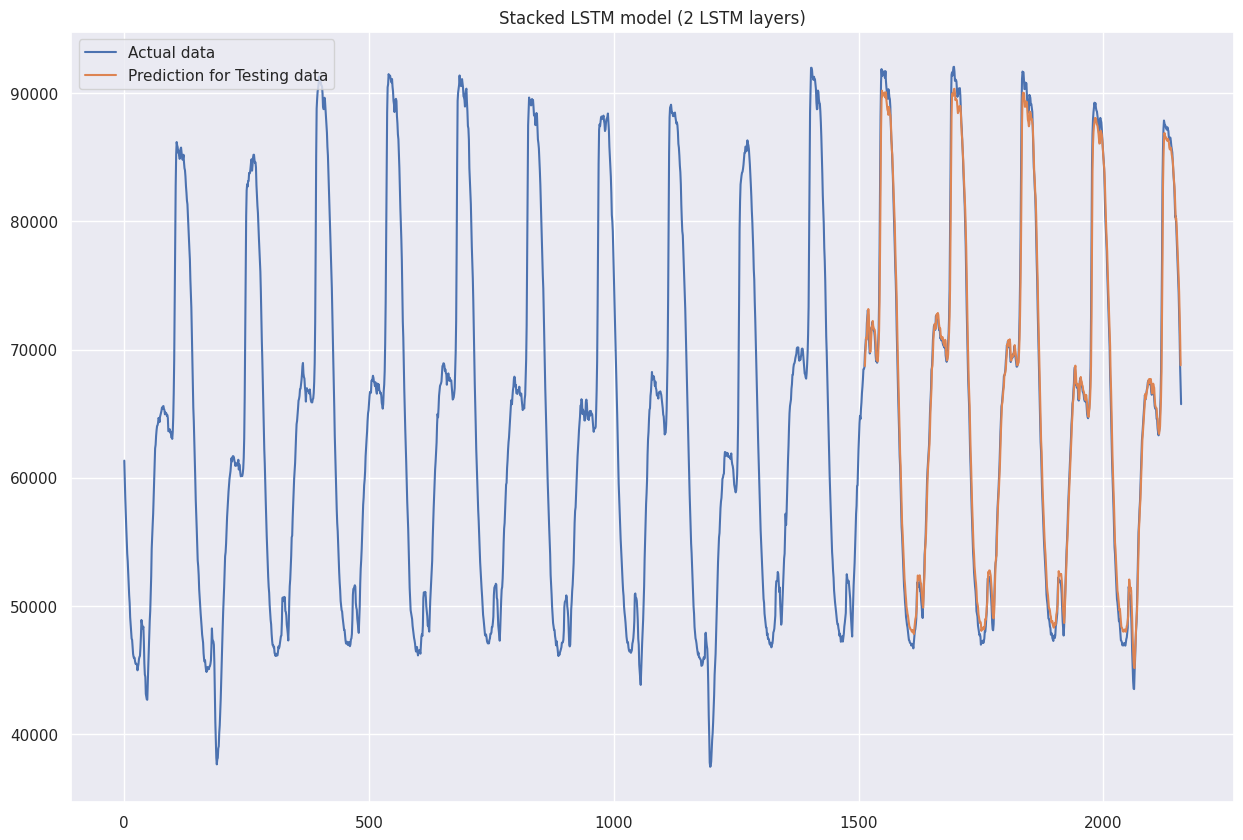

In [ ]:
# plot baseline and predictions
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(valPredictPlot)
# plt.plot(testPredictPlot)
# plt.legend(('Actual data', 'Prediction for Training data', 'Prediction for Validation data', 'Prediction for Testing data'), loc='upper left')
plt.plot(testPredictPlot)
plt.legend(('Actual data', 'Prediction for Testing data'), loc='upper left')
plt.title("Stacked LSTM model (2 LSTM layers)")
plt.show()

In [ ]:
df = data.values
actualTest = df[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :]
predictTest = testPredictPlot[len(trainPredict) + len(valPredict) + (look_back*3) +2: len(dataset)-1, :]

In [ ]:
actualTest.shape

(646, 1)

In [ ]:
predictTest.shape

(646, 1)

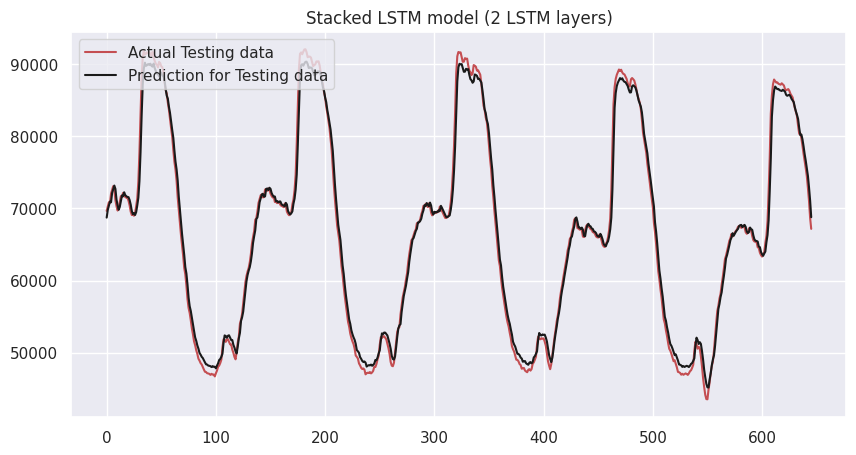

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(actualTest,'r-')
plt.plot(predictTest,'k-')
plt.legend(('Actual Testing data', 'Prediction for Testing data'), loc='upper left')
plt.title("Stacked LSTM model (2 LSTM layers)")
plt.show()